In [1]:
%matplotlib widget

In [2]:
import matplotlib

import numpy as np
from pathlib import Path
import flammkuchen as fl
from tifffile import imread
import matplotlib.pyplot as plt 
from fimpylab.core.lightsheet_experiment import LightsheetExperiment
from bouterin.plots.stimulus_log_plot import get_paint_function

from bouter.utilities import reliability 
from skimage.filters import threshold_otsu
import xarray as xr
from scipy.signal import detrend 

from motions.utilities import stim_vel_dir_dataframe, quantize_directions
import tifffile as tiff
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

In [3]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

In [4]:
# master_path =  Path(r"Z:\Hagar and Ot\E0040\v10\LS")
master_path = Path(r'\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS')
fish_list = list(master_path.glob("*f*"))
path = fish_list[7]
print(path)

\\portulab.synology.me\data\Hagar and Ot\E0040\v10\LS\240705_f2


In [5]:
suite2p_brain = fl.load(path / "data_from_suite2p_cells_brain.h5")
in_brain_idx = suite2p_brain['coords_idx']
num_traces = np.shape(in_brain_idx)[0]

In [6]:
traces = fl.load(path / "filtered_traces.h5", "/detr")[:, in_brain_idx]
sens_corr = fl.load(path / "sensory_regressors.h5", "/regressors")

In [127]:
coords = fl.load(path / "data_from_suite2p_cells.h5")['coords'][in_brain_idx]
anatomy = fl.load(path / "data_from_suite2p_cells.h5")['anatomy_stack']

In [128]:
coords

array([[  0.        , 839.64444444, 456.51111111],
       [  0.        , 780.32467532, 352.11688312],
       [  0.        , 572.99137931, 418.56896552],
       ...,
       [ 20.        , 283.95      , 671.32142857],
       [ 20.        , 289.05217391, 614.32173913],
       [ 20.        , 576.08421053, 384.91578947]])

In [8]:
# find most correlated trace with each direction 

sens_corr

,motion_0,motion_1,motion_2,motion_3,motion_4,motion_5,motion_6,motion_7
0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
3195,0.969899,0.000304,2.583053e-20,2.828847e-08,2.433436e-28,2.493316e-24,2.693516e-16,2.749820e-12
3196,0.976109,0.000242,2.050170e-20,2.245257e-08,1.931419e-28,1.978946e-24,2.137845e-16,2.182533e-12
3197,0.981038,0.000192,1.627221e-20,1.782062e-08,1.532968e-28,1.570690e-24,1.696809e-16,1.732278e-12
3198,0.984950,0.000152,1.291526e-20,1.414424e-08,1.216718e-28,1.246658e-24,1.346758e-16,1.374910e-12


In [9]:
reg_values = np.dot(traces.T, sens_corr.values)

In [10]:
n_t, n_neurons = np.shape(traces)
fs = 2

In [11]:
mean_traces = np.nanmean(traces.T, axis=0)
mean_regs = np.nanmean(sens_corr.values, axis=0)

traces_std = np.nanstd(traces.T, axis=0)
regs_std = np.nanstd(sens_corr.values, axis=0)


# Normalize the data
traces_normalized = (traces.T - mean_traces) / traces_std
regs_normalized = (sens_corr.values - mean_regs) / regs_std
    
dot_product = np.dot(traces_normalized, regs_normalized)
reg_corr_values = dot_product / (n_t - 1)

In [13]:
exp = LightsheetExperiment(path)
stimulus_log = exp.stimulus_log
stim_value, t_values = get_paint_function(stimulus_log, 'E0040_motions_cardinal')
stim_value = stim_value / 255
num_stim = np.shape(stim_value)[0]

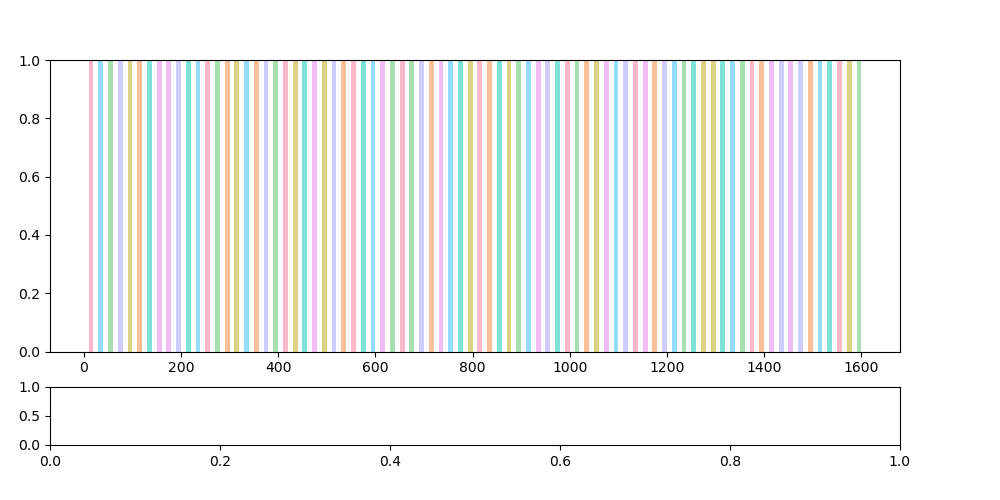

In [14]:
fig, ax = plt.subplots(2 ,1, figsize=(10, 5), gridspec_kw={'height_ratios': [5,1]})
plt.subplots_adjust(left=0.05)
for i in range(num_stim):
    ax[0].axvspan(
        t_values[i, 0] - t_values[0,0] + 10,
        t_values[i, 1] - t_values[0,0] + 10,
        facecolor=[stim_value[i, 0], stim_value[i, 1], stim_value[i, 2]],
        alpha=0.5,
    )

In [15]:
t_imaging = np.arange(n_t) / fs

high_corr_traces = np.zeros(8)
for direction in range(8):
    ind_trace = np.nanargmax(reg_corr_values[:,direction])
        
    high_corr_traces[direction] = int(ind_trace)
    print(int(ind_trace))    
    
    ax[0].plot(t_imaging, traces[:, int(ind_trace)] + (10 * direction), color='k')

14805
22806
24372
16950
20890
22783
9226
22605


In [16]:
beh_log = exp.behavior_log
tail = beh_log['tail_sum']
t_beh = beh_log['t']

### cleaning tail
tail_noise = np.where(np.abs(tail) < 0.2)[0]
clean_tail = np.copy(tail)
clean_tail[tail_noise] = 0

ax[1].plot(t_beh, clean_tail - 10, color='k')
ax[1].axis('off')
ax[0].axis('off')

(-79.9993654, 1679.9866734, -4.686616587638856, 77.42276589870453)

In [17]:
file_name = "most corr traces.jpg"
fig.savefig(path / file_name, dpi=300)
file_name = "most corr traces.pdf"
fig.savefig(path / file_name, dpi=300)

In [49]:
high_corr_traces = high_corr_traces.astype(int)

In [179]:
#Make color arr for example ROIs
col_order = [6, 1, 3, 7, 0, 5, 4, 2]
roi_cols = np.array([[stim_value[i, 0], stim_value[i, 1], stim_value[i, 2]] for i in col_order])

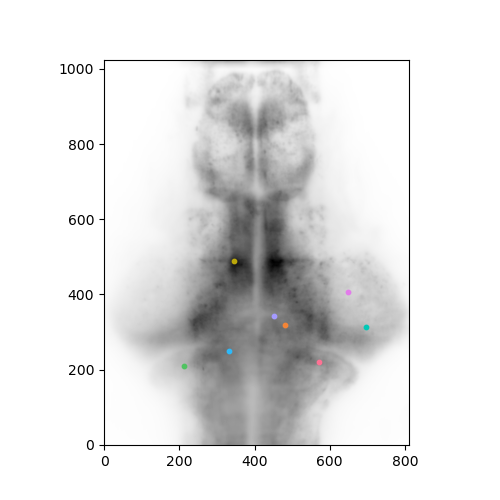

In [192]:
########### make a nice anatomy figure showing the cells location
### AVERAGE ANATOMY
fig_anat, ax_anat = plt.subplots(figsize=(5,5))
ax_anat.imshow(np.nanmean(anatomy, 0), cmap="gray_r")
# ax_anat[1].imshow(np.nanmean(anatomy, 2), cmap="gray_r")
ax_anat.invert_yaxis()
# ax_anat[1].invert_yaxis()

for i in range(8):
#     ax_anat.scatter(coords[high_corr_traces[i],2], coords[high_corr_traces[i],1], edgecolor=roi_cols[int(i)], facecolor='none', linewidth=1.5, s=15)
    ax_anat.scatter(coords[high_corr_traces[i],2], coords[high_corr_traces[i],1], color=roi_cols[int(i)], s=10)

In [193]:
fig_anat.savefig(path / 'Location of example neurons_v2.pdf', dpi=300)

In [112]:
morphed_coords = fl.load(path / 'registration' / 'to_h2b_baier_ref' / 'antspy' / 'mov_coords_transformed.h5')
ref_anatomy = fl.load(path / 'registration' / 'to_h2b_baier_ref' / 'antspy' / 'ref_mapped.h5')
mov_mapped = fl.load(path / 'registration' / 'to_h2b_baier_ref' / 'antspy' / 'mov_mapped.h5')
mov_coords_mapped = fl.load(path / 'registration' / 'to_h2b_baier_ref' / 'antspy' / 'mov_roi_coords_mapped.h5')


morphed_coords = morphed_coords[in_brain_idx]
mov_coords_mapped = mov_coords_mapped[in_brain_idx]

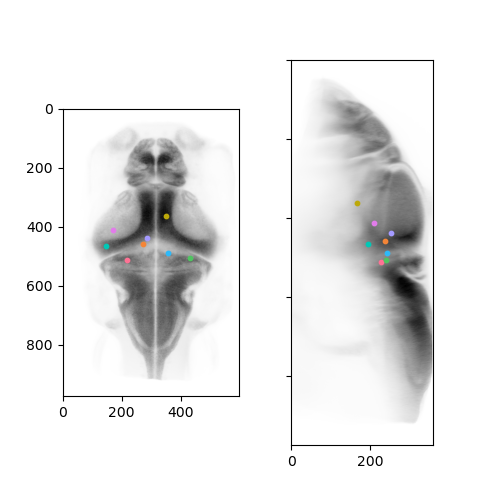

In [115]:
########### make a nice anatomy figure showing the cells location
### AVERAGE REFERENCE ANATOMY
fig_anat, ax_anat = plt.subplots(1,2, figsize=(5,5), sharey=True)
ax_anat[0].imshow(np.nanmean(ref_anatomy, 2).T, cmap="gray_r")
ax_anat[1].imshow(np.nanmean(ref_anatomy, 0), cmap="gray_r")

for i in range(8):
    ax_anat[0].scatter(morphed_coords[high_corr_traces[i],0], morphed_coords[high_corr_traces[i],1], color=roi_cols[int(i)], s=10)
    ax_anat[1].scatter(morphed_coords[high_corr_traces[i],2], morphed_coords[high_corr_traces[i],1], color=roi_cols[int(i)], s=10)


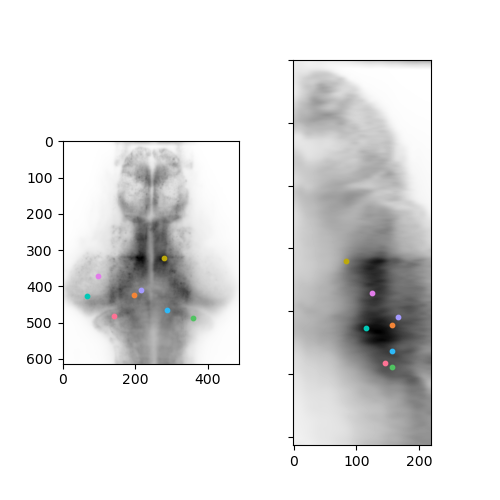

In [117]:
########### make a nice anatomy figure showing the cells location
### AVERAGE INTERPOLATED ANATOMY
fig_anat, ax_anat = plt.subplots(1,2, figsize=(5,5), sharey=True)
ax_anat[0].imshow(np.nanmean(mov_mapped, 2).T, cmap="gray_r")
ax_anat[1].imshow(np.nanmean(mov_mapped, 0), cmap="gray_r")

for i in range(8):
    ax_anat[0].scatter(mov_coords_mapped[high_corr_traces[i],0], mov_coords_mapped[high_corr_traces[i],1], color=roi_cols[int(i)], s=10)
    ax_anat[1].scatter(mov_coords_mapped[high_corr_traces[i],2], mov_coords_mapped[high_corr_traces[i],1], color=roi_cols[int(i)], s=10)


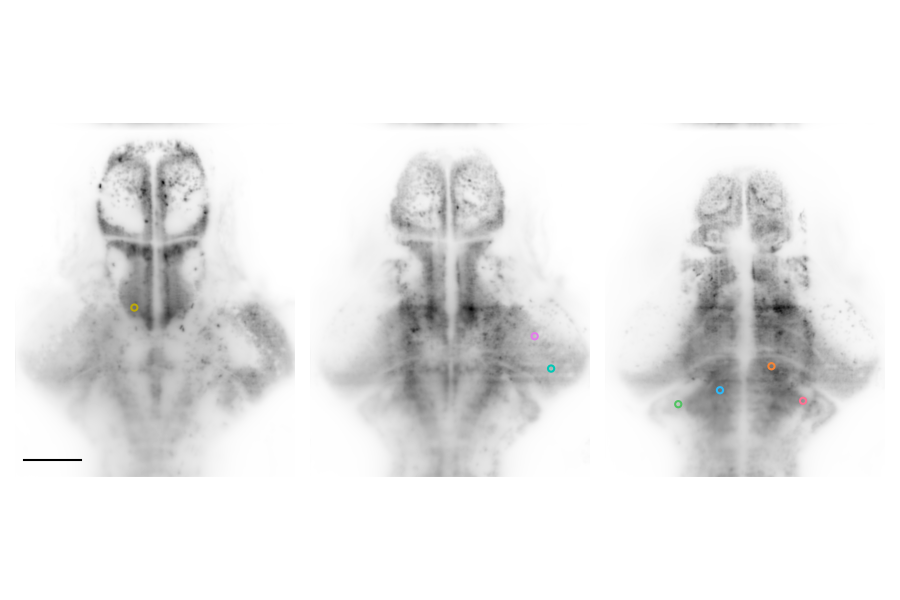

In [205]:
########### make a nice anatomy figure showing the cells location
### AVERAGE SLICES
zmin = coords[high_corr_traces][:, 0].min()
zmax = coords[high_corr_traces][:, 0].max()
zmin, zmax

steps = 3
z_step = (zmax-zmin)/steps
z_step

fig_anat, axes = plt.subplots(1,steps, figsize=(9, 6))

for i, plane in enumerate(np.arange(zmin, zmax, z_step)):
    axes[int(i)].imshow(anatomy[int(plane):int(plane+z_step)].mean(0), cmap="gray_r", aspect='equal')
    
    sel_rois = np.nonzero(np.logical_and(coords[high_corr_traces][:, 0]>=plane, coords[high_corr_traces][:, 0]<(plane+z_step)))
    axes[int(i)].scatter(coords[high_corr_traces[sel_rois[0]],2], coords[high_corr_traces[sel_rois[0]],1], edgecolor=roi_cols[sel_rois[0]], facecolor='none', linewidth=1.5, s=20)
    
for ax in axes:
    ax.invert_yaxis()
    ax.axis('off')
    
scale_bar_len = 100
scale_bar_xpos = 25
scale_bar_ypos1 = 50
fs = 8
microns_per_px = 0.6

axes[0].plot((scale_bar_xpos, scale_bar_xpos+(scale_bar_len/microns_per_px)), (scale_bar_ypos1, scale_bar_ypos1), c='black')
plt.tight_layout()

In [207]:
fig_anat.savefig(path / 'Location of example neurons_v2.png', dpi=300)

In [230]:
piezo_min = exp['imaging']['microscope_config']['lightsheet']['scanning']['z']['piezo_min']
piezo_max = exp['imaging']['microscope_config']['lightsheet']['scanning']['z']['piezo_max']
n_planes = exp['imaging']['microscope_config']['lightsheet']['scanning']['triggering']['n_planes']

microns_per_plane = (piezo_max - piezo_min)/n_planes

In [232]:
z_step*microns_per_plane

27.829968795256562

In [40]:
high_corr_traces

array([14805., 22806., 24372., 16950., 20890., 22783.,  9226., 22605.])

In [34]:
stim_value.shape

(80, 3)

In [21]:
color_list = ['k', 'k', 'k', 'k', 'k', 'k', 'k', 'k']
title_list = ['→', '↘', '↓', '↙', '←', '↖', '↑', '↗']

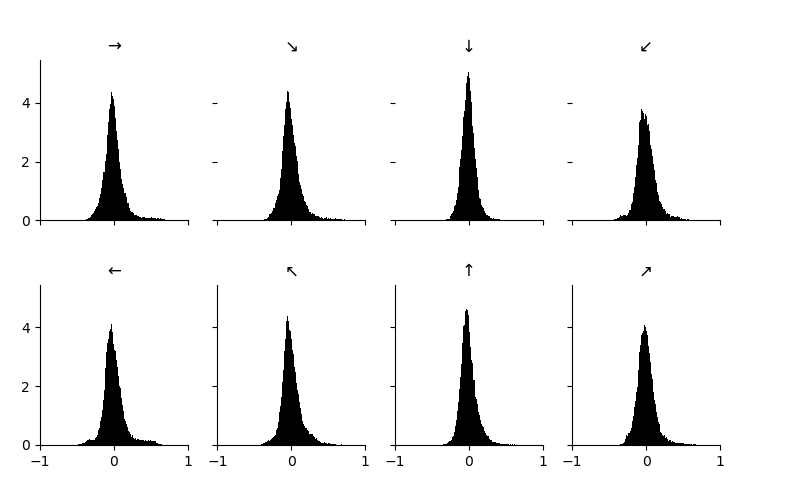

In [22]:
########## plot the distribution of correlation values per direction 
fig2, ax2 = plt.subplots(2,4, figsize=(8, 5), sharex=True, sharey=True)
plt.subplots_adjust(left=0.05, wspace=0.2, hspace=0.4)

for direction in range(4):
    ax2[0, direction].hist(reg_corr_values[:,direction], bins=100, density=True, color=color_list[direction])
    ax2[0, direction].spines['right'].set_visible(False)
    ax2[0, direction].spines['top'].set_visible(False)
    ax2[0, direction].set_xlim(-1,1)
    ax2[0, direction].set_title(title_list[direction])
    
    ax2[1, direction-4].hist(reg_corr_values[:,direction+4], bins=100, density=True, color=color_list[direction+4])
    ax2[1, direction-4].spines['right'].set_visible(False)
    ax2[1, direction-4].spines['top'].set_visible(False)
    ax2[1, direction-4].set_xlim(-1,1)
    ax2[1, direction-4].set_title(title_list[direction+4])
    if direction > 0:
        ax2[0, direction].spines['left'].set_visible(False)

In [23]:
file_name = "corr dist.jpg"
fig2.savefig(path / file_name, dpi=300)
file_name = "corr dist.pdf"
fig2.savefig(path / file_name, dpi=300)

In [24]:
high_corr_traces = high_corr_traces.astype(int)

In [25]:
############## plot tuning curves for selected neurons 

In [26]:
# load reordered traces 
trial_traces = fl.load(path / 'reliability_index_arr.h5')['trial_traces']

print(np.shape(trial_traces))

(31763, 10, 320)


In [27]:
selected_traces = trial_traces[high_corr_traces]

selected_traces_avg = np.nanmean(selected_traces, axis=1)
np.shape(selected_traces_avg)

(8, 320)

In [28]:
tuning_curve_selected = np.zeros((8,8)) #n_neurons, n_dirs
trial_len = 20

for i in range(8):
    t1 = i*trial_len*2 + trial_len
    t2 = t1 + trial_len
    print(t1, t2)
    
    tuning_curve_selected[:,i] = np.nanmean(selected_traces_avg[:, t1:t2], axis=1)
    

20 40
60 80
100 120
140 160
180 200
220 240
260 280
300 320


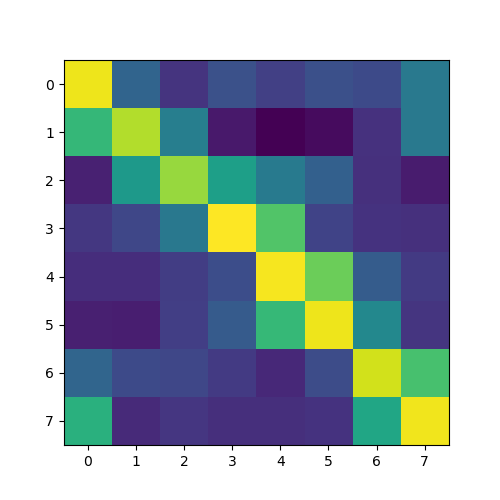

In [29]:
fig4, ax4= plt.subplots(1 ,1, figsize=(5, 5))
ax4.imshow(tuning_curve_selected)


14805
22806
24372
16950
20890
22783
9226
22605


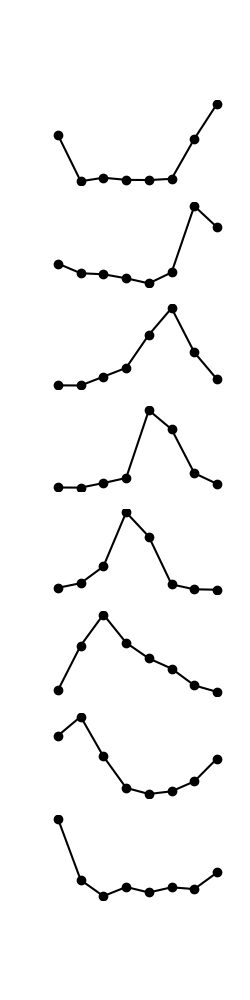

In [30]:
fig3, ax3 = plt.subplots(8 ,1, figsize=(2.5, 10))
fig3.subplots_adjust(hspace=0.2, bottom=0.1, top=0.9, left=0.2)

t_imaging = np.arange(n_t) / fs

high_corr_traces = np.zeros(8)
for direction in range(8):
    ind_trace = np.nanargmax(reg_corr_values[:,direction])
        
    high_corr_traces[direction] = int(ind_trace)
    print(int(ind_trace))    
    
    ax3[7-direction].plot(tuning_curve_selected[direction], color='k')
    ax3[7-direction].scatter(np.arange(8), tuning_curve_selected[direction], color='k')
    ax3[7-direction].axis('off')


In [31]:
file_name = "example tuning curve.jpg"
fig3.savefig(path / file_name, dpi=300)
file_name = "example tuning curve.pdf"
fig3.savefig(path / file_name, dpi=300)